PSNR: 33.58


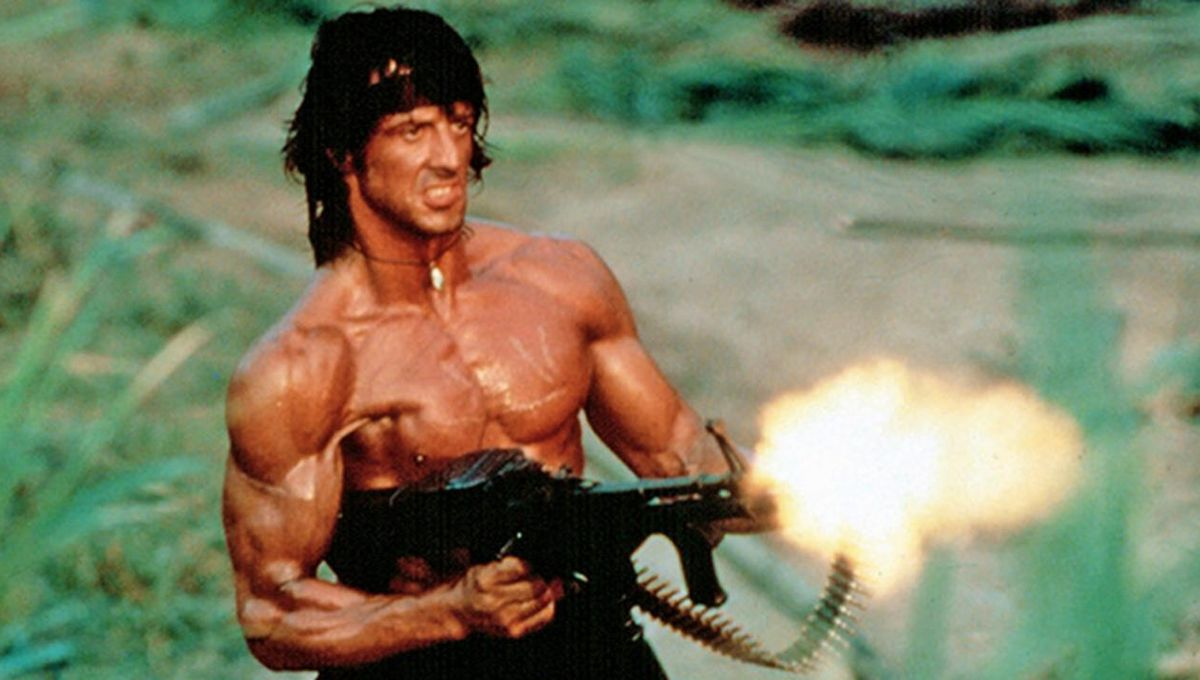

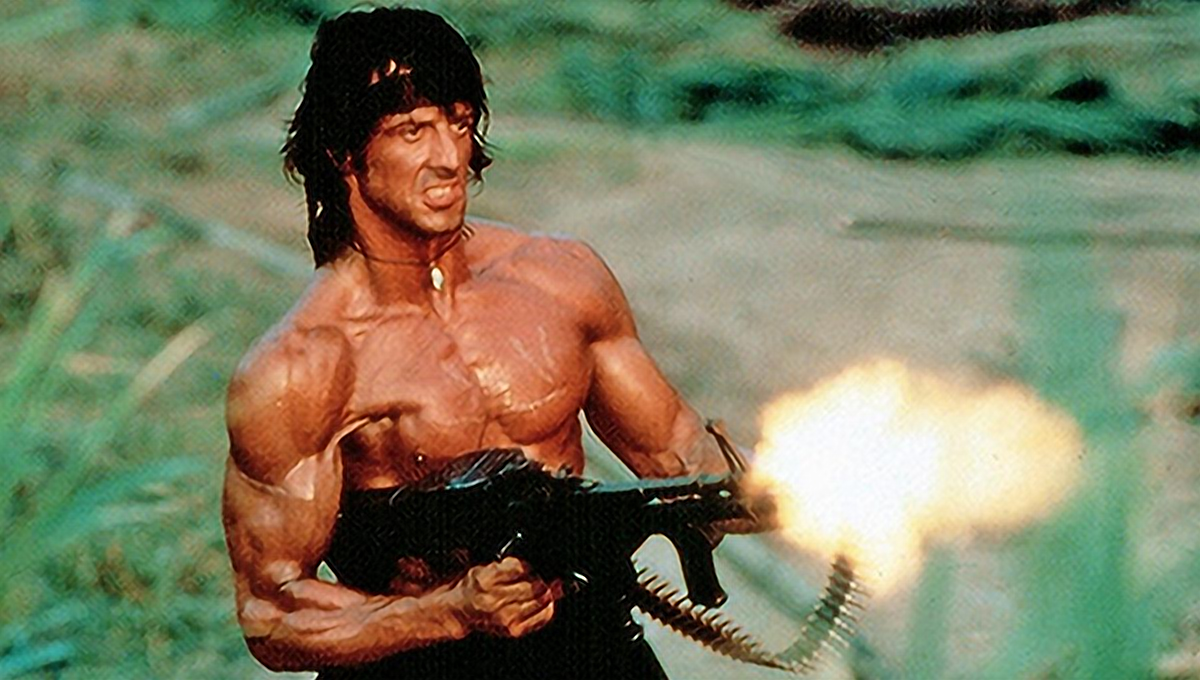

In [17]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image
import matplotlib.pyplot as plt
from PIL import Image

from models import SRCNN
from utils import convert_rgb_to_ycbcr, convert_ycbcr_to_rgb, calc_psnr

weights="weights/srcnn_x4.pth"
image="data/rambo.jpg"
upscale=2

cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SRCNN().to(device)



state_dict = model.state_dict()
for n, p in torch.load(weights, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()

imageraw = pil_image.open(image)
image=imageraw.convert('RGB')

image_width = (image.width // upscale) * upscale
image_height = (image.height // upscale) * upscale


image = np.array(image).astype(np.float32)
ycbcr = convert_rgb_to_ycbcr(image)

y = ycbcr[..., 0]
y /= 255.
y = torch.from_numpy(y).to(device)
y = y.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y).clamp(0.0, 1.0)

psnr = calc_psnr(y, preds)
print('PSNR: {:.2f}'.format(psnr))

preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
output = pil_image.fromarray(output)




display(imageraw)
display(output)

In [24]:
im1_matrix = np.array(imageraw)

im2_matrix = np.array(output)
print(np.shape(im1_matrix))
print(np.shape(im2_matrix))

(680, 1200, 3)
(680, 1200, 3)
